In [1]:
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from config import *
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report
import shap
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
import ast
from matplotlib import pyplot as plt
import seaborn as sns


/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fakenewsnet = pd.read_csv('../data/wf/FakeNewsNet_wf.csv')
isot = pd.read_csv('../data/wf/FakeNewsISOT_wf.csv')
fakenewskaggle = pd.read_csv('../data/wf/FakeNewsKaggle_wf.csv')
buzfeed_political = pd.read_csv('../data/wf/FakeNewsBuzfeedPolitical_wf.csv')
celebrity = pd.read_csv('../data/wf/FakeNewsCelebrity_wf.csv')
fakenewsamt = pd.read_csv('../data/wf/FakeNewsAMT_wf.csv')
fn_randompolitical = pd.read_csv('../data/wf/FakeNewsRandomPolitical_wf.csv')
fn_politfalse = pd.read_csv('../data/wf/FakeNewsPolitFalse_wf.csv')
fn_satirical = pd.read_csv('../data/wf/FakeNewsSatirical_wf.csv')
fn_mcintire = pd.read_csv('../data/wf/FakeNewsMcintire_wf.csv')

datasets = {
    'FakeNewsNet' : fakenewsnet,
    'ISOT' : isot,
    'FakeNewsKaggle' : fakenewskaggle,
    'FakeNewsAMT' : fakenewsamt,
    'FakeNewsRandomPolitical' : fn_randompolitical,
    'FakeNewsCelebrity' : celebrity,
    'FakeNewsBuzfeedPolitical' : buzfeed_political,
    'FakeNewsPolitFalse' : fn_politfalse,
    'FakeNewsSatirical' : fn_satirical,
}

In [3]:
# create a dataframe with some statistics about all datasets (number of words of the 'text' column, etc.), and the populate it with information about each dataset
def get_dataset_stats(dataset, name):
    dataset_stats = pd.DataFrame()
    dataset_stats['dataset'] = [name]
    dataset_stats['num_rows'] = [dataset.shape[0]]
    dataset_stats['num_cols'] = [dataset.shape[1]]
    dataset_stats['avg_word_len'] = [dataset['text'].str.split().str.len().mean()]
    dataset_stats['avg_char_len'] = [dataset['text'].str.len().mean()]
    dataset_stats['num_unique_words'] = [dataset['text'].str.split().apply(lambda x: len(set(x))).sum()]
    return dataset_stats

dataset_stats = pd.DataFrame()
for dataset_name, dataset in datasets.items():
    dataset_stats = pd.concat([dataset_stats, get_dataset_stats(dataset, dataset_name)])



In [4]:
for dataset_name, dataset in datasets.items():
    print(dataset_name)
    print(dataset['label'].value_counts())

FakeNewsNet
label
0    201
1    171
Name: count, dtype: int64
ISOT
label
1    22313
0    21416
Name: count, dtype: int64
FakeNewsKaggle
label
0    10358
1     7401
Name: count, dtype: int64
FakeNewsAMT
label
1    240
0    240
Name: count, dtype: int64
FakeNewsRandomPolitical
label
1    75
0    75
Name: count, dtype: int64
FakeNewsCelebrity
label
1    250
0    250
Name: count, dtype: int64
FakeNewsBuzfeedPolitical
label
0    53
1    48
Name: count, dtype: int64
FakeNewsPolitFalse
label
0    137
1    137
Name: count, dtype: int64
FakeNewsSatirical
label
0    180
1    180
Name: count, dtype: int64


In [5]:
dataset_stats

,dataset,num_rows,num_cols,avg_word_len,avg_char_len,num_unique_words
0,FakeNewsNet,372,131,548.991935,3086.836022,96195
0,ISOT,43729,131,415.148140,2514.475200,10117730
0,FakeNewsKaggle,17759,131,823.822062,4864.268484,7094138
0,FakeNewsAMT,480,131,122.710417,734.508333,41832
0,FakeNewsRandomPolitical,150,131,587.266667,3611.246667,47569
0,FakeNewsCelebrity,500,131,431.696000,2443.442000,114849
0,FakeNewsBuzfeedPolitical,101,131,935.891089,5571.990099,42692
0,FakeNewsPolitFalse,274,131,579.434307,3505.781022,79996
0,FakeNewsSatirical,360,131,542.975000,3235.230556,105644


In [6]:
feature_sets = {
    'Moral' : MORAL_FEATURES,
    'ReadabilityGrades' : READABILITY_GRADE_FEATURES,
    'ReadabilitySentenceInfo' : READABILITY_SENTENCEINFO_FEATURES,
    'ReadabilitySentenceBegininng' : READABILITY_SENTENCEBEGINNING_FEATURES,
    'ReadabilityWordUsage' : READABILITY_WORDUSAGE_FEATURES,
    'AllReadability' : READABILITY_GRADE_FEATURES + READABILITY_SENTENCEINFO_FEATURES + READABILITY_SENTENCEBEGINNING_FEATURES + READABILITY_WORDUSAGE_FEATURES,
    'Sentiment' : SENTIMENT_FEATURES,
    'Subjectivity' : ['subjectivity'],
    'Emotion' : EMOTION_FEATURES,
    'LIWCLinguistic' : LIWC_LINGUISTIC_FEATURES,
    'LIWCAffectiveProcesses' : LIWC_AFFECTIVEPROCESSES_FEATURES,
    'LIWCSocialProcesses' : LIWC_SOCIALPROCESSES_FEATURES,
    'LIWCCognitiveProcesses' : LIWC_COGNITIVEPROCESSES_FEATURES,
    'LIWCPerceptualProcesses' : LIWC_PERCEPTUALPROCESSES_FEATURES,
    'LIWCBiologicalProcesses' : LIWC_BIOLOGICALPROCESSES_FEATURES,
    'LIWCDrives' : LIWC_DRIVES_FEATURES,
    'LIWCTimeOrientation' : LIWC_TIMEORIENTATION_FEATURES,
    'LIWCRelativity' : LIWC_RELATIVITY_FEATURES,
    'LIWCPersonalConcerns' : LIWC_PERSONALCONCERNS_FEATURES,
    'LIWCInformalLanguage' : LIWC_INFORMALLANGUAGE_FEATURES,
    'AllLIWC' : LIWC_LINGUISTIC_FEATURES + LIWC_AFFECTIVEPROCESSES_FEATURES + LIWC_SOCIALPROCESSES_FEATURES + LIWC_COGNITIVEPROCESSES_FEATURES + LIWC_PERCEPTUALPROCESSES_FEATURES + LIWC_BIOLOGICALPROCESSES_FEATURES 
        + LIWC_DRIVES_FEATURES + LIWC_TIMEORIENTATION_FEATURES + LIWC_RELATIVITY_FEATURES + LIWC_PERSONALCONCERNS_FEATURES + LIWC_INFORMALLANGUAGE_FEATURES,
    'All' : MORAL_FEATURES + READABILITY_GRADE_FEATURES + READABILITY_SENTENCEINFO_FEATURES + READABILITY_SENTENCEBEGINNING_FEATURES + READABILITY_WORDUSAGE_FEATURES + SENTIMENT_FEATURES + LIWC_LINGUISTIC_FEATURES + LIWC_AFFECTIVEPROCESSES_FEATURES + LIWC_SOCIALPROCESSES_FEATURES + LIWC_COGNITIVEPROCESSES_FEATURES + LIWC_PERCEPTUALPROCESSES_FEATURES + LIWC_BIOLOGICALPROCESSES_FEATURES 
        + LIWC_DRIVES_FEATURES + LIWC_TIMEORIENTATION_FEATURES + LIWC_RELATIVITY_FEATURES + LIWC_PERSONALCONCERNS_FEATURES + LIWC_INFORMALLANGUAGE_FEATURES + ['subjectivity'] + EMOTION_FEATURES

}

In [7]:
def reduce_memory_usage(df):   
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

def get_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    # x = x.drop(columns=drops)
    return drops

def get_low_score_features(df, feature_names):
    np.random.seed(24091993)
    df['random_var_1'] = np.random.random(size=len(df))
    df['random_var_2'] = np.random.random(size=len(df))
    
    X = df[feature_names]
    y = df['label']

    ig = mutual_info_regression(X, y)

    # Create a dictionary of feature importance scores
    feature_scores = {}
    for i in range(len(feature_names)):
        feature_scores[feature_names[i]] = ig[i]
    # Add the random variables to the feature scores dictionary
    feature_scores['random_var_1'] = ig[-2]  # Assuming ig has the importance scores for the added random variables
    feature_scores['random_var_2'] = ig[-1]

    # Sort the features by importance score in descending order
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Get the importance score of 'random_var_1'
    random_var_1_score = feature_scores['random_var_1']
    random_var_2_score = feature_scores['random_var_2']

    # Get the features whose importance score is lower than the importance score of 'random_var_1'
    less_important_features = [feature for feature, score in sorted_features if (score < random_var_1_score or score < random_var_2_score) ]

    return set(less_important_features)

In [24]:
cols_to_drop = []
for dataset_name, dataset in datasets.items():
    print('---Dataset {dataset_name}---'.format(dataset_name=dataset_name))
    df = dataset[feature_sets['All'] + ['label']]
    df = df.loc[:,~df.columns.duplicated()].copy()
    datasets[dataset_name] = reduce_memory_usage(df)    

---Dataset FakeNewsNet---
Memory usage of dataframe is 0.3634033203125 MB
Memory usage of dataframe after reduction 0.09058761596679688 MB
Reduced by 75.07243029895868 % 
---Dataset ISOT---
Memory usage of dataframe is 42.7042236328125 MB
Memory usage of dataframe after reduction 10.634444236755371 MB
Reduced by 75.09744158284096 % 
---Dataset FakeNewsAMT---
Memory usage of dataframe is 0.4688720703125 MB
Memory usage of dataframe after reduction 0.116851806640625 MB
Reduced by 75.07810466024473 % 
---Dataset FakeNewsRandomPolitical---
Memory usage of dataframe is 0.1466064453125 MB
Memory usage of dataframe after reduction 0.03660011291503906 MB
Reduced by 75.03512697751873 % 
---Dataset FakeNewsCelebrity---
Memory usage of dataframe is 0.4884033203125 MB
Memory usage of dataframe after reduction 0.12171554565429688 MB
Reduced by 75.0788865283679 % 
---Dataset FakeNewsBuzfeedPolitical---
Memory usage of dataframe is 0.0987548828125 MB
Memory usage of dataframe after reduction 0.024683

## Feature analysis

In [8]:
# Lista de nombres de las features
features = feature_sets['All']

In [9]:

# Definir el umbral de correlación alta
correlation_threshold = 0.9

# Función para encontrar las features altamente correlacionadas en un dataset
def get_highly_correlated_features(df, threshold):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return highly_correlated

# Encontrar las features altamente correlacionadas en todos los datasets
all_highly_correlated_features = []
for dataset_name, dataset in datasets.items():
    correlated_features = get_highly_correlated_features(dataset[features], correlation_threshold)
    all_highly_correlated_features.append(set(correlated_features))

# Encontrar la intersección de features altamente correlacionadas en todos los datasets
common_highly_correlated_features = set.intersection(*all_highly_correlated_features)

print("Features altamente correlacionadas en todos los datasets:")
print(common_highly_correlated_features)

# Eliminar las features altamente correlacionadas de los datasets
datasets = {name: df.drop(columns=common_highly_correlated_features) for name, df in datasets.items()}

Features altamente correlacionadas en todos los datasets:
{'readability_wordtypes', 'readability_syllables', 'readability_words', 'readability_RIX', 'readability_characters_per_word', 'readability_SMOGIndex', 'readability_syll_per_word', 'readability_FleschReadingEase', 'readability_sentences', 'readability_characters'}


In [10]:
# remove common_highly_correlated_features from features
features = [feature for feature in features if feature not in common_highly_correlated_features]

# Crear un DataFrame vacío para almacenar los resultados
results_fa = pd.DataFrame(columns=features, index=datasets.keys())

# Iterar sobre cada dataset
for dataset_name, df in datasets.items():
    print('---- Dataset %s' % dataset_name)

    df = df.copy()
    
    # scale dataset
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])


    # Separar las noticias falsas y legítimas
    df_false = df[df['label'] == 1]
    df_legit = df[df['label'] == 0]
    
    # Calcular la diferencia de medias para cada feature
    for feature in features:
        mean_false = df_false[feature].mean()
        mean_legit = df_legit[feature].mean()
        difference = mean_false - mean_legit
        
        # Almacenar la diferencia en el DataFrame de resultados
        results_fa.at[dataset_name, feature] = difference

---- Dataset FakeNewsNet
---- Dataset ISOT
---- Dataset FakeNewsKaggle
---- Dataset FakeNewsAMT
---- Dataset FakeNewsRandomPolitical
---- Dataset FakeNewsCelebrity
---- Dataset FakeNewsBuzfeedPolitical
---- Dataset FakeNewsPolitFalse
---- Dataset FakeNewsSatirical


In [11]:
# Asumiendo que ya tienes el DataFrame results_df con las diferencias normalizadas

# Crear una lista para almacenar las top 20 features de cada dataset
top_features_per_dataset_list = []

# Iterar sobre cada dataset para encontrar las 20 features con mayor diferencia positiva
for dataset_name in results_fa.index:
    # Ordenar las features por la diferencia positiva
    top_features = results_fa.loc[dataset_name].sort_values(ascending=False).head(20).index
    # Añadir las features a la lista
    for feature in top_features:
        top_features_per_dataset_list.append({'Feature': feature, 'Dataset': dataset_name})

# Convertir la lista a un DataFrame
top_features_per_dataset = pd.DataFrame(top_features_per_dataset_list)

# Contar cuántas veces aparece cada feature en los top 20 de todos los datasets
feature_counts = top_features_per_dataset['Feature'].value_counts()



In [12]:
feature_counts.head(10)

Feature
liwc_certain                    7
readability_type_token_ratio    6
liwc_focuspresent               6
liwc_adverb                     6
liwc_cogproc                    6
liwc_function                   6
liwc_ppron                      5
liwc_verb                       5
liwc_swear                      5
liwc_pronoun                    5
Name: count, dtype: int64

In [13]:
# Asumiendo que ya tienes el DataFrame results_df con las diferencias normalizadas

# Crear una lista para almacenar las top 20 features con mayor diferencia negativa de cada dataset
top_negative_features_per_dataset_list = []

# Iterar sobre cada dataset para encontrar las 20 features con mayor diferencia negativa
for dataset_name in results_fa.index:
    # Ordenar las features por la diferencia negativa
    top_negative_features = results_fa.loc[dataset_name].sort_values(ascending=True).head(20).index
    # Añadir las features a la lista
    for feature in top_negative_features:
        top_negative_features_per_dataset_list.append({'Feature': feature, 'Dataset': dataset_name})

# Convertir la lista a un DataFrame
top_negative_features_per_dataset = pd.DataFrame(top_negative_features_per_dataset_list)

# Contar cuántas veces aparece cada feature en los top 20 de todos los datasets
negative_feature_counts = top_negative_features_per_dataset['Feature'].value_counts()


In [14]:
# Mostrar los resultados
negative_feature_counts.head(10)

Feature
liwc_hear                              8
readability_complex_words_dc           8
readability_complex_words              7
readability_long_words                 7
readability_article                    7
readability_preposition                6
readability_sentences_per_paragraph    6
readability_ARI                        6
readability_interrogative              6
readability_Kincaid                    6
Name: count, dtype: int64

In [15]:
# Asumiendo que ya tienes el DataFrame results_df con las diferencias normalizadas

# Función para obtener las 20 features con menor diferencia en cada dataset
def get_top_20_smallest_diff_features(dataframe):
    top_20_features = {}
    for dataset in dataframe.index:
        smallest_diff_features = dataframe.loc[dataset].abs().sort_values().head(20).index
        top_20_features[dataset] = smallest_diff_features
    return top_20_features

# Obtener las 20 features con menor diferencia en cada dataset
top_20_features = get_top_20_smallest_diff_features(results_fa)

# Contar la frecuencia de cada feature en los top 20 de todos los datasets
feature_counts = pd.Series(np.concatenate(list(top_20_features.values()))).value_counts()

# Si deseas ver el resultado de una manera más estructurada
top_20_features_df = pd.DataFrame.from_dict(top_20_features, orient='index').T


In [16]:
feature_counts.head(10)

readability_paragraphs    9
emotion_anticip           9
liwc_money                5
liwc_sad                  5
liwc_risk                 4
liwc_anx                  4
liwc_family               4
liwc_cause                4
emotion_anticipation      4
emotion_sadness           4
Name: count, dtype: int64

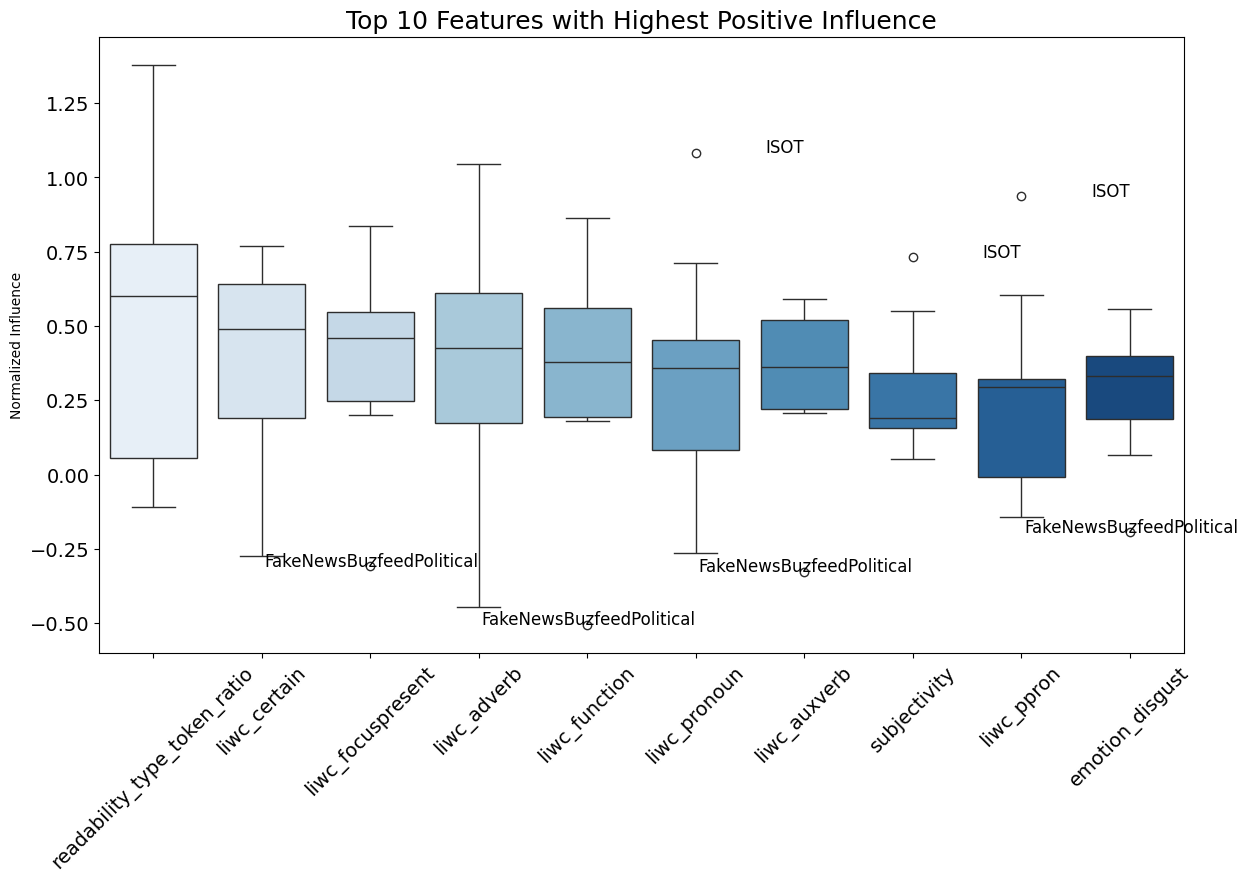

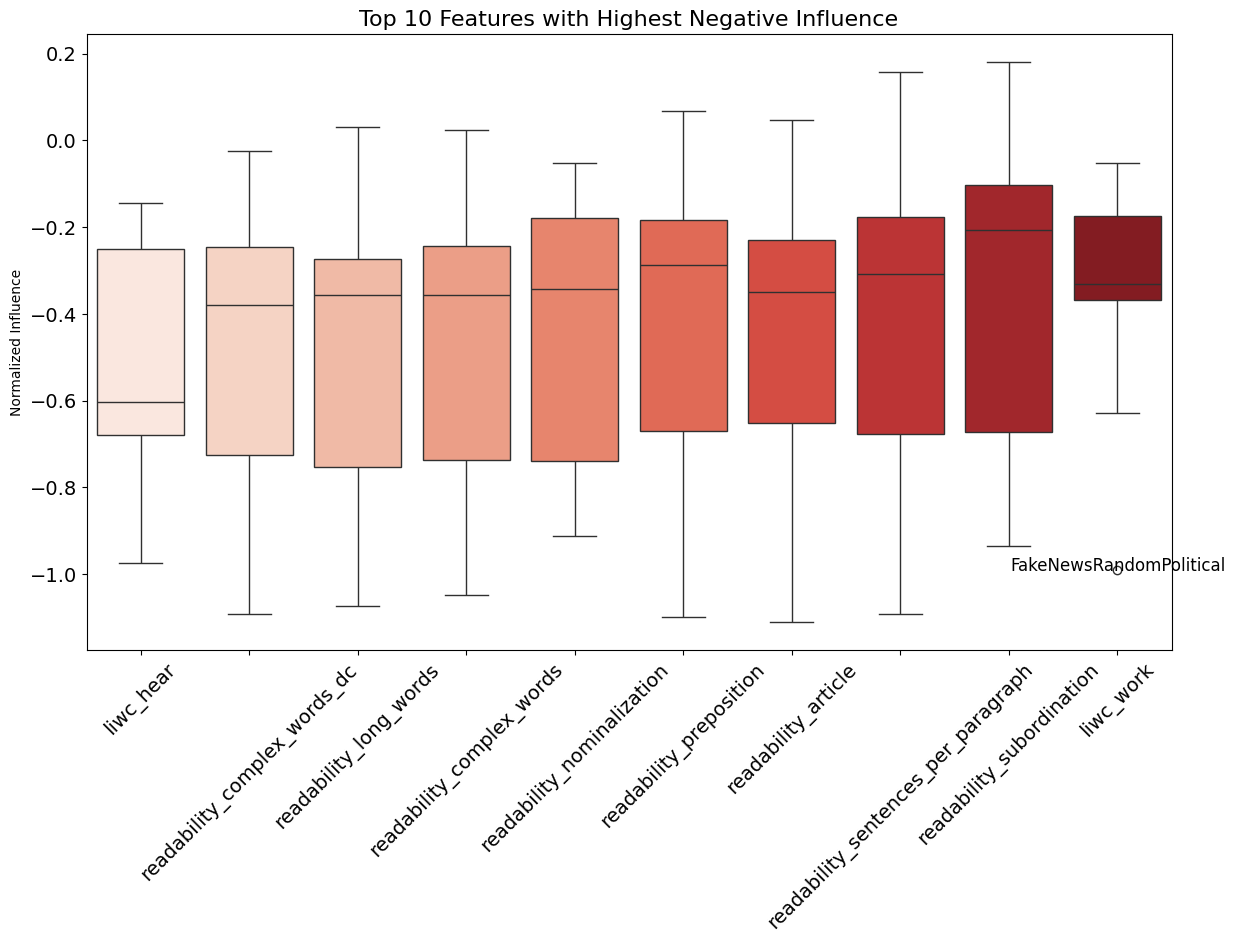

In [70]:
# Asumiendo que ya tienes el DataFrame results_fa con las diferencias normalizadas

# Calcular la media de la influencia de cada feature en cada dataset
mean_influences = results_fa.mean(axis=0)

# Identificar las 10 features con la mayor influencia positiva
top_10_positive_features = mean_influences.sort_values(ascending=False).head(10).index

# Identificar las 10 features con la mayor influencia negativa
top_10_negative_features = mean_influences.sort_values(ascending=True).head(10).index

# Identificar las 20 features con la mayor influencia positiva
top_20_positive_features = mean_influences.sort_values(ascending=False).head(10).index

# Identificar las 20 features con la mayor influencia negativa
top_20_negative_features = mean_influences.sort_values(ascending=True).head(10).index

# Filtrar el DataFrame results_fa para estas features
top_positive_df = results_fa[top_10_positive_features]
top_negative_df = results_fa[top_10_negative_features]

# Convertir todas las columnas a tipo numérico por si acaso
top_positive_df = top_positive_df.apply(pd.to_numeric)
top_negative_df = top_negative_df.apply(pd.to_numeric)

# Función para anotar los outliers con el nombre del dataset
def annotate_outliers(ax, data, dataset_names):
    for i, feature in enumerate(data.columns):
        y = data[feature]
        x = np.full(len(y), i + 1)
        Q1 = np.percentile(y, 25)
        Q3 = np.percentile(y, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = y[(y < lower_bound) | (y > upper_bound)]
        for outlier_idx in outliers.index:
            xi = i + 1
            yi = outliers[outlier_idx]
            dataset_name = outlier_idx
            ax.text(xi, yi, dataset_name, ha='right', fontsize=12)

# Crear un diagrama de cajas para las 10 features con la mayor influencia positiva
plt.figure(figsize=(14, 8))
plt.yticks(fontsize=14)
ax = sns.boxplot(data=top_positive_df, palette="Blues")
plt.title('Top 10 Features with Highest Positive Influence', fontsize=18)
plt.ylabel('Normalized Influence')
plt.xticks(rotation=45, fontsize=14)
annotate_outliers(ax, top_positive_df, results_fa.index)
plt.show()

# Crear un diagrama de cajas para las 10 features con la mayor influencia negativa
plt.figure(figsize=(14, 8))
plt.yticks(fontsize=14)
ax = sns.boxplot(data=top_negative_df, palette="Reds")
plt.title('Top 10 Features with Highest Negative Influence', fontsize=16)
plt.ylabel('Normalized Influence')
plt.xticks(rotation=45, fontsize=14)
annotate_outliers(ax, top_negative_df, results_fa.index)
plt.show()

In [18]:
top_10_positive_features

Index(['readability_type_token_ratio', 'liwc_certain', 'liwc_focuspresent',
       'liwc_adverb', 'liwc_function', 'liwc_pronoun', 'liwc_auxverb',
       'subjectivity', 'liwc_ppron', 'emotion_disgust'],
      dtype='object')

In [19]:
top_10_negative_features

Index(['liwc_hear', 'readability_complex_words_dc', 'readability_long_words',
       'readability_complex_words', 'readability_nominalization',
       'readability_preposition', 'readability_article',
       'readability_sentences_per_paragraph', 'readability_subordination',
       'liwc_work'],
      dtype='object')

In [20]:
top_20_global_features = top_10_positive_features.tolist() + top_10_negative_features.tolist()

In [21]:
top_40_global_features = top_20_positive_features.tolist() + top_20_negative_features.tolist()

In [22]:
top_20_global_features

['readability_type_token_ratio',
 'liwc_certain',
 'liwc_focuspresent',
 'liwc_adverb',
 'liwc_function',
 'liwc_pronoun',
 'liwc_auxverb',
 'subjectivity',
 'liwc_ppron',
 'emotion_disgust',
 'liwc_hear',
 'readability_complex_words_dc',
 'readability_long_words',
 'readability_complex_words',
 'readability_nominalization',
 'readability_preposition',
 'readability_article',
 'readability_sentences_per_paragraph',
 'readability_subordination',
 'liwc_work']

## Analysis by algorithms

In [23]:
algorithms = [
    'DecisionTree',
    'LinearSVC' ,
    'LogisticRegression',
    'RandomForest',
    'XGBoost',
    'CatBoost',
]

def get_algorithm(name):
    if name == 'XGBoost' : 
        return XGBClassifier(n_jobs=-1)
    elif name == 'CatBoost' :
        return CatBoostClassifier(verbose=False)
    elif name == 'DecisionTree' :
        return DecisionTreeClassifier(class_weight='balanced')
    elif name == 'SVC' :
        return SVC(class_weight='balanced')
    elif name == 'LinearSVC':
        return LinearSVC(class_weight='balanced')
    elif name == 'RandomForest' :
        return RandomForestClassifier(class_weight='balanced', n_jobs=-1)
    elif name == 'LogisticRegression' :
        return LogisticRegression(class_weight='balanced', n_jobs=-1, max_iter=1000000)

## Algorithms with differen number of features

In [73]:
np.random.seed(240993)

# create dataframe for results
results_df_mf = pd.DataFrame(columns=['dataset', 'num_features', 'algorithm', 'fit_time', 'precision_weighted_mean', 'precision_weighted_std', 'recall_weighted_mean', 'recall_weighted_std', 'f1_weighted_mean', 'f1_weighted_std', 'precision_macro_mean', 'precision_macro_std', 'recall_macro_mean', 'recall_macro_std', 'f1_macro_mean', 'f1_macro_std', 'precision_micro_mean', 'precision_micro_std', 'recall_micro_mean', 'recall_micro_std', 'f1_micro_mean', 'f1_micro_std'])
for dataset_name, dataset in datasets.items():
    print('---Dataset {dataset_name}---'.format(dataset_name=dataset_name))

    for num_features in [3, 5, 8, 10, 15, 20]:
        print('---Number of features {num_features}---'.format(num_features=num_features))
        
        # select the top num_features from top_20_global_features head and the top num_features from the tail
        top_num_features_head = top_40_global_features[:num_features]
        top_num_features_tail = top_40_global_features[-num_features:]
        top_num_features = top_num_features_head + top_num_features_tail

        X = dataset[top_num_features]
        y = dataset['label']

        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        for algorithm_name in algorithms:
            print('---Algorithm {algorithms_name}---'.format(algorithms_name=algorithm_name))
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=24091993)
            scores = cross_validate(get_algorithm(algorithm_name), X, y, cv=cv, scoring=['precision_weighted', 'recall_weighted', 'f1_weighted', 'precision_micro', 'recall_micro', 'f1_micro', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

            # add results to dataframe using concat method
            results_df_mf = pd.concat([results_df_mf, pd.DataFrame({
                'dataset' : [dataset_name],
                'num_features' : [num_features],
                'algorithm' : [algorithm_name],
                'fit_time' : np.mean(scores['fit_time']),
                'precision_weighted_mean' : np.mean(scores['test_precision_weighted']),
                'precision_weighted_std' : np.std(scores['test_precision_weighted']),
                'recall_weighted_mean' : np.mean(scores['test_recall_weighted']),
                'recall_weighted_std' : np.std(scores['test_recall_weighted']),
                'f1_weighted_mean' : np.mean(scores['test_f1_weighted']),
                'f1_weighted_std' : np.std(scores['test_f1_weighted']),
                'precision_macro_mean' : np.mean(scores['test_precision_macro']),
                'precision_macro_std' : np.std(scores['test_precision_macro']),
                'recall_macro_mean' : np.mean(scores['test_recall_macro']),
                'recall_macro_std' : np.std(scores['test_recall_macro']),
                'f1_macro_mean' : np.mean(scores['test_f1_macro']),
                'f1_macro_std' : np.std(scores['test_f1_macro']),
                'precision_micro_mean' : np.mean(scores['test_precision_micro']),
                'precision_micro_std' : np.std(scores['test_precision_micro']),
                'recall_micro_mean' : np.mean(scores['test_recall_micro']),
                'recall_micro_std' : np.std(scores['test_recall_micro']),
                'f1_micro_mean' : np.mean(scores['test_f1_micro']),
                'f1_micro_std' : np.std(scores['test_f1_micro'])
            })], ignore_index=True)

---Dataset FakeNewsNet---
---Number of features 3---
---Algorithm DecisionTree---


/tmp/ipykernel_20041/2262883120.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_mf = pd.concat([results_df_mf, pd.DataFrame({


---Algorithm LinearSVC---
---Algorithm LogisticRegression---
---Algorithm RandomForest---
---Algorithm XGBoost---
---Algorithm CatBoost---
---Number of features 5---
---Algorithm DecisionTree---
---Algorithm LinearSVC---
---Algorithm LogisticRegression---
---Algorithm RandomForest---
---Algorithm XGBoost---
---Algorithm CatBoost---
---Number of features 8---
---Algorithm DecisionTree---
---Algorithm LinearSVC---
---Algorithm LogisticRegression---
---Algorithm RandomForest---
---Algorithm XGBoost---
---Algorithm CatBoost---
---Number of features 10---
---Algorithm DecisionTree---
---Algorithm LinearSVC---
---Algorithm LogisticRegression---
---Algorithm RandomForest---
---Algorithm XGBoost---
---Algorithm CatBoost---
---Number of features 15---
---Algorithm DecisionTree---
---Algorithm LinearSVC---
---Algorithm LogisticRegression---
---Algorithm RandomForest---
---Algorithm XGBoost---
---Algorithm CatBoost---
---Number of features 20---
---Algorithm DecisionTree---
---Algorithm LinearSVC

In [78]:
results_df_mf.groupby(['num_features', 'algorithm'])[['fit_time', 'f1_weighted_mean', 'f1_weighted_std']].mean()

fit_time  f1_weighted_mean  f1_weighted_std
num_features algorithm                                                       
3            CatBoost             7.380649          0.713854         0.044883
             DecisionTree         0.070106          0.670899         0.038889
             LinearSVC            0.008583          0.723227         0.046967
             LogisticRegression   0.020884          0.721195         0.052354
             RandomForest         1.287345          0.719009         0.049743
             XGBoost              0.105613          0.702578         0.044975
5            CatBoost             8.937944          0.742916         0.044183
             DecisionTree         0.100904          0.683289         0.037334
             LinearSVC            0.018118          0.734280         0.042740
             LogisticRegression   0.026673          0.736698         0.043436
             RandomForest         1.699757          0.743094         0.037450
             XGBoost              0.132497          0.723744         0.040620
8            CatBoost            11.131641          0.745884         0.045327
             DecisionTree         0.154388          0.689854         0.048156
             LinearSVC            0.037225          0.748463         0.049402
             LogisticRegression   0.028020          0.754511         0.051735
             RandomForest         2.053981          0.755281         0.038317
             XGBoost              0.183881          0.742172         0.048333
10           CatBoost            11.940710          0.772594         0.033512
             DecisionTree         0.175270          0.716228         0.048886
             LinearSVC            0.047713          0.766756         0.040371
             LogisticRegression   0.041282          0.766609         0.043439
             RandomForest         1.918322          0.770810         0.032949
             XGBoost              0.230312          0.760889         0.040376
15           CatBoost            15.377531          0.775347         0.033319
             DecisionTree         0.264596          0.709420         0.045910
             LinearSVC            0.068497          0.766594         0.040671
             LogisticRegression   0.054301          0.768080         0.042010
             RandomForest         2.311650          0.774655         0.028490
             XGBoost              0.297469          0.760889         0.040376
20           CatBoost            18.881831          0.771019         0.039823
             DecisionTree         0.348695          0.711543         0.042417
             LinearSVC            0.097614          0.767439         0.040618
             LogisticRegression   0.056092          0.767642         0.041480
             RandomForest         2.681396          0.773668         0.032391
             XGBoost              0.426037          0.760889         0.040376

In [77]:
results_df_mf.groupby(['num_features', 'dataset'])[['fit_time', 'f1_weighted_mean', 'f1_weighted_std']].mean()

fit_time  f1_weighted_mean  \
num_features dataset                                                 
3            FakeNewsAMT                0.783767          0.579637   
             FakeNewsBuzfeedPolitical   0.468799          0.769900   
             FakeNewsCelebrity          0.806975          0.633065   
             FakeNewsKaggle             3.194881          0.710233   
             FakeNewsNet                0.570308          0.596076   
             FakeNewsPolitFalse         0.701639          0.713599   
             FakeNewsRandomPolitical    0.586353          0.723614   
             FakeNewsSatirical          0.815519          0.822405   
             ISOT                       5.381529          0.827613   
5            FakeNewsAMT                1.090386          0.622840   
             FakeNewsBuzfeedPolitical   0.518088          0.761395   
             FakeNewsCelebrity          0.935094          0.620179   
             FakeNewsKaggle             3.749862          0.746128   
             FakeNewsNet                0.763172          0.648988   
             FakeNewsPolitFalse         0.893296          0.727665   
             FakeNewsRandomPolitical    0.684085          0.717820   
             FakeNewsSatirical          1.006776          0.858591   
             ISOT                       6.733081          0.842425   
8            FakeNewsAMT                1.425517          0.622234   
             FakeNewsBuzfeedPolitical   0.722269          0.754288   
             FakeNewsCelebrity          1.267967          0.660428   
             FakeNewsKaggle             4.524623          0.766263   
             FakeNewsNet                1.005816          0.654891   
             FakeNewsPolitFalse         1.290544          0.735826   
             FakeNewsRandomPolitical    0.821022          0.734962   
             FakeNewsSatirical          1.383767          0.858447   
             ISOT                       7.942179          0.866905   
10           FakeNewsAMT                1.485255          0.629420   
             FakeNewsBuzfeedPolitical   0.789547          0.759473   
             FakeNewsCelebrity          1.546498          0.680424   
             FakeNewsKaggle             4.868425          0.784348   
             FakeNewsNet                1.230382          0.691452   
             FakeNewsPolitFalse         1.384219          0.749883   
             FakeNewsRandomPolitical    0.920536          0.764736   
             FakeNewsSatirical          1.569841          0.867867   
             ISOT                       7.735710          0.903225   
15           FakeNewsAMT                1.728396          0.635284   
             FakeNewsBuzfeedPolitical   0.990846          0.759367   
             FakeNewsCelebrity          1.993333          0.684882   
             FakeNewsKaggle             5.845609          0.784063   
             FakeNewsNet                1.684997          0.685029   
             FakeNewsPolitFalse         1.972191          0.754627   
             FakeNewsRandomPolitical    1.338514          0.761401   
             FakeNewsSatirical          2.189929          0.864580   
             ISOT                       9.817248          0.903244   
20           FakeNewsAMT                2.316004          0.632089   
             FakeNewsBuzfeedPolitical   1.172342          0.759347   
             FakeNewsCelebrity          2.628289          0.684968   
             FakeNewsKaggle             7.325441          0.784980   
             FakeNewsNet                2.647985          0.688908   
             FakeNewsPolitFalse         2.480766          0.750145   
             FakeNewsRandomPolitical    1.500660          0.760116   
             FakeNewsSatirical          2.643037          0.864206   
             ISOT                      11.022975          0.903541   

                                       f1_weighted_std  
num_features dataset                                    
3    

In [87]:
results_df_mf[(results_df_mf['num_features']==20) & (results_df_mf['algorithm']=='XGBoost')]

,dataset,num_features,algorithm,fit_time,precision_weighted_mean,precision_weighted_std,recall_weighted_mean,recall_weighted_std,f1_weighted_mean,f1_weighted_std,...,recall_macro_mean,recall_macro_std,f1_macro_mean,f1_macro_std,precision_micro_mean,precision_micro_std,recall_micro_mean,recall_micro_std,f1_micro_mean,f1_micro_std
34,FakeNewsNet,20,XGBoost,0.162161,0.691265,0.022641,0.688324,0.024020,0.686216,0.025033,...,0.684990,0.024715,0.683714,0.025451,0.688324,0.024020,0.688324,0.024020,0.688324,0.024020
70,ISOT,20,XGBoost,1.597842,0.924362,0.003610,0.924352,0.003611,0.924349,0.003615,...,0.924288,0.003659,0.924315,0.003620,0.924352,0.003611,0.924352,0.003611,0.924352,0.003611
106,FakeNewsKaggle,20,XGBoost,1.361873,0.803839,0.006638,0.804268,0.006671,0.803994,0.006625,...,0.797355,0.006609,0.798138,0.006769,0.804268,0.006671,0.804268,0.006671,0.804268,0.006671
142,FakeNewsAMT,20,XGBoost,0.185138,0.642445,0.048233,0.641667,0.047781,0.641230,0.047739,...,0.641667,0.047781,0.641230,0.047739,0.641667,0.047781,0.641667,0.047781,0.641667,0.047781
178,FakeNewsRandomPolitical,20,XGBoost,0.041821,0.747381,0.049501,0.740000,0.053333,0.737524,0.055101,...,0.740000,0.053333,0.737524,0.055101,0.740000,0.053333,0.740000,0.053333,0.740000,0.053333
214,FakeNewsCelebrity,20,XGBoost,0.245258,0.697320,0.026117,0.696000,0.025768,0.695507,0.025735,...,0.696000,0.025768,0.695507,0.025735,0.696000,0.025768,0.696000,0.025768,0.696000,0.025768
250,FakeNewsBuzfeedPolitical,20,XGBoost,0.034471,0.806491,0.051861,0.751905,0.084882,0.740779,0.094871,...,0.760707,0.070998,0.743262,0.090991,0.751905,0.084882,0.751905,0.084882,0.751905,0.084882
286,FakeNewsPolitFalse,20,XGBoost,0.112044,0.755278,0.056016,0.748215,0.058894,0.746313,0.060343,...,0.748942,0.058228,0.746488,0.060109,0.748215,0.058894,0.748215,0.058894,0.748215,0.058894
322,FakeNewsSatirical,20,XGBoost,0.093727,0.873705,0.044243,0.872222,0.044270,0.872088,0.044323,...,0.872222,0.044270,0.872088,0.044323,0.872222,0.044270,0.872222,0.044270,0.872222,0.044270


In [88]:
results_df_mf[(results_df_mf['num_features']==20) & (results_df_mf['algorithm']=='XGBoost')].groupby(['dataset'])[['fit_time', 'f1_weighted_mean', 'f1_weighted_std']].mean()

,fit_time,f1_weighted_mean,f1_weighted_std
dataset,,,
FakeNewsAMT,0.185138,0.641230,0.047739
FakeNewsBuzfeedPolitical,0.034471,0.740779,0.094871
FakeNewsCelebrity,0.245258,0.695507,0.025735
FakeNewsKaggle,1.361873,0.803994,0.006625
FakeNewsNet,0.162161,0.686216,0.025033
FakeNewsPolitFalse,0.112044,0.746313,0.060343
FakeNewsRandomPolitical,0.041821,0.737524,0.055101
FakeNewsSatirical,0.093727,0.872088,0.044323
ISOT,1.597842,0.924349,0.003615


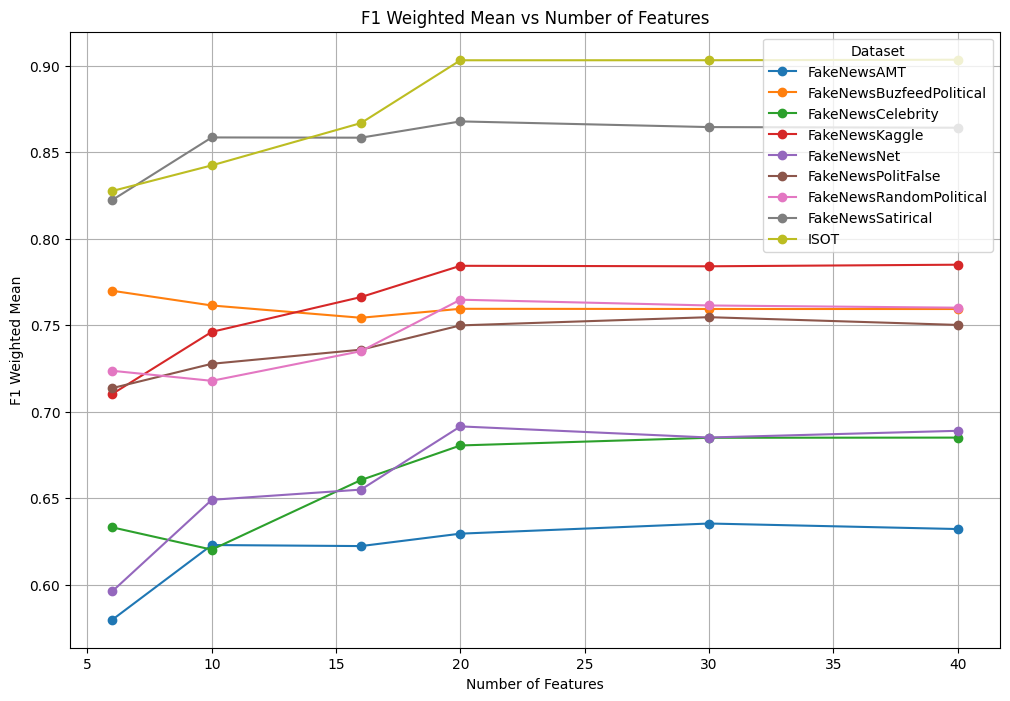

In [76]:
grouped_results = results_df_mf.groupby(['num_features', 'dataset'])[['f1_weighted_mean']].mean().reset_index()

# Hacer el plot
plt.figure(figsize=(12, 8))

# Obtener el número único de datasets
datasets = grouped_results['dataset'].unique()

# Plotear cada dataset
for dataset in datasets:
    subset = grouped_results[grouped_results['dataset'] == dataset]
    plt.plot(subset['num_features']*2, subset['f1_weighted_mean'], marker='o', label=dataset)

# Configurar el gráfico
plt.title('F1 Weighted Mean vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('F1 Weighted Mean')
plt.legend(title='Dataset')
plt.grid(True)

# Mostrar el gráfico
plt.show()

## Explainability for LogReg

In [25]:
top_20_global_features

['readability_type_token_ratio',
 'liwc_certain',
 'liwc_focuspresent',
 'liwc_adverb',
 'liwc_function',
 'liwc_pronoun',
 'liwc_auxverb',
 'subjectivity',
 'liwc_ppron',
 'emotion_disgust',
 'liwc_hear',
 'readability_complex_words_dc',
 'readability_long_words',
 'readability_complex_words',
 'readability_nominalization',
 'readability_preposition',
 'readability_article',
 'readability_sentences_per_paragraph',
 'readability_subordination',
 'liwc_work']

In [34]:
# create dataframe for results
results_shap = {}

np.random.seed(240993)

algorithm_name = 'XGBoost'

for datasets_name, dataset in datasets.items():
    print('---Dataset {datasets_name}---'.format(datasets_name=datasets_name))
    results_shap[datasets_name] = {}

    X = dataset[top_20_global_features]
    y = dataset['label']
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # create model

    model = get_algorithm(algorithm_name)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2409199)
    
    model.fit(X_train, y_train)

    # print classification report
    print(classification_report(y_test, model.predict(X_test)))
    
    model = get_algorithm(algorithm_name).fit(X, y)
    
    background_X = shap.maskers.Independent(X, max_samples=100)

    # create explainer
    explainer = shap.Explainer(model.predict, background_X)

    # create shap values
    shap_values = explainer(X)

    results_shap[datasets_name]['features'] = top_20_global_features
    results_shap[datasets_name]['shap_values'] = shap_values
    

---Dataset FakeNewsNet---
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        43
           1       0.61      0.72      0.66        32

    accuracy                           0.68        75
   macro avg       0.68      0.68      0.68        75
weighted avg       0.69      0.68      0.68        75



PermutationExplainer explainer: 373it [00:13,  7.84it/s]                         


---Dataset ISOT---
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4289
           1       0.92      0.93      0.92      4457

    accuracy                           0.92      8746
   macro avg       0.92      0.92      0.92      8746
weighted avg       0.92      0.92      0.92      8746



PermutationExplainer explainer: 43730it [39:03, 18.52it/s]                             


---Dataset FakeNewsKaggle---
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2047
           1       0.78      0.76      0.77      1505

    accuracy                           0.80      3552
   macro avg       0.80      0.80      0.80      3552
weighted avg       0.80      0.80      0.80      3552



PermutationExplainer explainer: 17760it [16:40, 17.59it/s]                           


---Dataset FakeNewsAMT---
              precision    recall  f1-score   support

           0       0.65      0.64      0.65        50
           1       0.62      0.63      0.62        46

    accuracy                           0.64        96
   macro avg       0.64      0.64      0.64        96
weighted avg       0.64      0.64      0.64        96



PermutationExplainer explainer: 481it [00:26, 10.54it/s]                         


---Dataset FakeNewsRandomPolitical---
              precision    recall  f1-score   support

           0       0.83      0.62      0.71        16
           1       0.67      0.86      0.75        14

    accuracy                           0.73        30
   macro avg       0.75      0.74      0.73        30
weighted avg       0.76      0.73      0.73        30

---Dataset FakeNewsCelebrity---
              precision    recall  f1-score   support

           0       0.71      0.62      0.67        48
           1       0.69      0.77      0.73        52

    accuracy                           0.70       100
   macro avg       0.70      0.70      0.70       100
weighted avg       0.70      0.70      0.70       100



PermutationExplainer explainer: 501it [00:28, 11.52it/s]                         


---Dataset FakeNewsBuzfeedPolitical---
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.67      0.67      0.67         9

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21

---Dataset FakeNewsPolitFalse---
              precision    recall  f1-score   support

           0       0.77      0.69      0.73        29
           1       0.69      0.77      0.73        26

    accuracy                           0.73        55
   macro avg       0.73      0.73      0.73        55
weighted avg       0.73      0.73      0.73        55



PermutationExplainer explainer: 275it [00:14,  5.87it/s]                         


---Dataset FakeNewsSatirical---
              precision    recall  f1-score   support

           0       0.77      0.82      0.79        33
           1       0.84      0.79      0.82        39

    accuracy                           0.81        72
   macro avg       0.80      0.81      0.80        72
weighted avg       0.81      0.81      0.81        72



PermutationExplainer explainer: 361it [00:18,  8.16it/s]                         


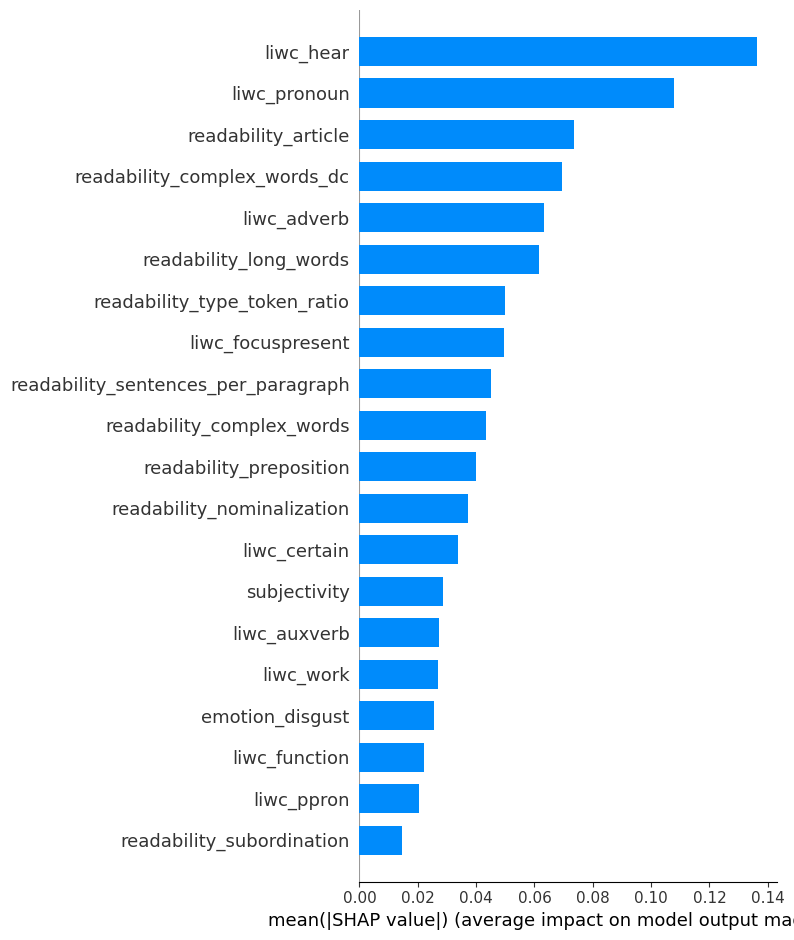

In [92]:
sv_agg = results_shap['ISOT']['shap_values'].values

for dataset_name in datasets.keys():
    sv_agg = np.concatenate((sv_agg, results_shap[dataset_name]['shap_values'].values), axis=0)

shap.summary_plot(sv_agg, feature_names=results_shap[dataset_name]['features'], plot_type="bar")